<a href="https://colab.research.google.com/github/seonjing/Advanced_Machine_Learning_8team/blob/main/2023712638_%EC%9E%84%EC%88%98%EB%B9%88_TranAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Transformer 기반 TranAD 모델 정의
class TranAD(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2):
        super(TranAD, self).__init__()
        self.encoder = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=128,
            dropout=0.1,
            activation='relu'
        )
        self.input_projection = nn.Linear(input_dim, d_model)
        self.output_projection = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        # 입력 데이터 차원 변환
        src = self.input_projection(src).permute(1, 0, 2)  # (batch, seq_len, dim) -> (seq_len, batch, dim)
        tgt = self.input_projection(tgt).permute(1, 0, 2)  # 동일 차원 변환
        output = self.encoder(src, tgt)  # Transformer에 src와 tgt를 전달
        output = output.permute(1, 0, 2)  # 복원 (seq_len, batch, dim) -> (batch, seq_len, dim)
        output = self.output_projection(output)  # 차원 변환
        return output

# 이상 점수 계산 함수
def calculate_anomaly_score(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2, dim=-1)

# 데이터 전처리 함수
def preprocess_data(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

# KaggleHub로 데이터셋 다운로드
import kagglehub
path = kagglehub.dataset_download("boltzmannbrain/nab")

print("Path to dataset files:", path)

# 데이터 파일 경로 확인
dataset_file = os.path.join("/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1")


/Users/beenee/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/beenee/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1


In [ ]:
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

print("Available CSV files:")
for csv_file in csv_files:
    print(csv_file)

Available CSV files:
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_257a54.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_c6585a.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv
/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv
/Users/beenee/.cache/kag

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch

# KaggleHub로 데이터셋 다운로드
import kagglehub
path = kagglehub.dataset_download("boltzmannbrain/nab")

print("Path to dataset files:", path)

# 데이터 파일 경로 확인
dataset_file = os.path.join(path, "realTweets","realTweets", "Twitter_volume_GOOG.csv")

# 데이터 로드
data = pd.read_csv(dataset_file)
print(data.head())

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['value'].values.reshape(-1, 1))

# 시계열 윈도우 생성
def preprocess_data(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 10
sequences = preprocess_data(scaled_data, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
train_data = sequences[:split_index]
test_data = sequences[split_index:]

train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)

# train_data와 test_data의 개수 확인하기
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

print(f"Train data size: {train_data_size}")
print(f"Test data size: {test_data_size}")

Path to dataset files: /Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1
             timestamp  value
0  2015-02-26 21:42:53     35
1  2015-02-26 21:47:53     41
2  2015-02-26 21:52:53     32
3  2015-02-26 21:57:53     36
4  2015-02-26 22:02:53     32
Train data size: 12665
Test data size: 3167


In [ ]:
import os

# 경로 확인
dataset_path = '/Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1/realTweets/realTweets'
print("Dataset directory structure:", os.listdir(dataset_path))

Dataset directory structure: ['Twitter_volume_AAPL.csv', 'Twitter_volume_UPS.csv', 'Twitter_volume_KO.csv', 'Twitter_volume_GOOG.csv', 'Twitter_volume_CVS.csv', 'Twitter_volume_FB.csv', 'Twitter_volume_IBM.csv', 'Twitter_volume_CRM.csv', 'Twitter_volume_PFE.csv', 'Twitter_volume_AMZN.csv']


Path to dataset files: /Users/beenee/.cache/kagglehub/datasets/boltzmannbrain/nab/versions/1
Train data size: 12665
Test data size: 3167


/Users/beenee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


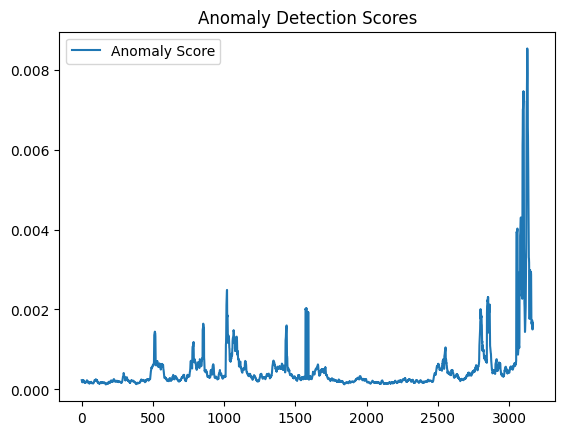

F1 Score: 0.0000


/Users/beenee/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# KaggleHub로 데이터셋 다운로드
import kagglehub
path = kagglehub.dataset_download("boltzmannbrain/nab")
print("Path to dataset files:", path)

# 데이터 파일 경로 확인
dataset_file = os.path.join(path, "realTweets", "realTweets", 'Twitter_volume_GOOG.csv')
data = pd.read_csv(dataset_file)

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['value'].values.reshape(-1, 1))

# 시계열 윈도우 생성
def preprocess_data(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 10
sequences = preprocess_data(scaled_data, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
train_data = sequences[:split_index]
test_data = sequences[split_index:]

train_data = torch.tensor(train_data, dtype=torch.float32)
test_data = torch.tensor(test_data, dtype=torch.float32)


# train_data와 test_data의 개수 확인하기
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

print(f"Train data size: {train_data_size}")
print(f"Test data size: {test_data_size}")


# TranAD 모델 정의 (Transformer 기반 모델)
class TranADModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers):
        super(TranADModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads),
            num_layers=num_layers
        )
        self.output_projection = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.encoder(x)
        x = self.output_projection(x)
        return x

# 모델 초기화
input_dim = 1
model_dim = 64
num_heads = 8
num_layers = 4
model = TranADModel(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads, num_layers=num_layers)

# 이상 점수 계산 함수
def calculate_anomaly_score(original, reconstructed):
    return torch.mean((original - reconstructed) ** 2).item()

# 이상 레이블 생성 (임계값을 기준으로 수동으로 레이블링)
threshold = 0.6  # 예시: 임계값 0.6 초과인 경우 이상으로 간주
true_labels = [1 if value > threshold else 0 for value in data['value']]

# test_data에 맞는 true_labels 생성 (test_data 크기에 맞춰야 함)
test_true_labels = true_labels[-len(test_data):]

# 모델 평가
model.eval()
anomaly_scores = []

with torch.no_grad():
    for sequence in test_data:
        sequence = sequence.unsqueeze(0)  # 배치 차원 추가
        reconstructed = model(sequence)
        score = calculate_anomaly_score(sequence, reconstructed)
        anomaly_scores.append(score)

# 이상 점수 시각화
plt.plot(anomaly_scores, label='Anomaly Score')
plt.title("Anomaly Detection Scores")
plt.legend()
plt.show()

# F1, Precision, Recall, AUC 계산
# 임계값을 기준으로 탐지된 이상 여부를 결정
detected_anomalies = [1 if score > 0.1 else 0 for score in anomaly_scores]  # threshold 값 조정

from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve
f1 = f1_score(test_true_labels, detected_anomalies)
precision = precision_score(test_true_labels, detected_anomalies)
recall = recall_score(test_true_labels, detected_anomalies)
pr_auc = average_precision_score(test_true_labels, anomaly_scores)

print(f"F1 Score: {f1:.4f}")

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


# 데이터 경로 설정
dataset_path = "/Users/beenee/Downloads/realKnownCause"  # 데이터셋 폴더 경로
label_file = os.path.join(dataset_path, "labels.json")  # 레이블 파일 경로

## 논문 성능 구현

#### 1) 논문 제시 파라미터

In [ ]:
# TranAD 모델 정의
class TranADModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_layers, dropout_rate):
        super(TranADModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Transformer 인코더 레이어
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim,   # hidden unit의 차원
            nhead=num_heads,     # attention 헤드 개수
            dim_feedforward=ff_layers,  # Feed-forward 레이어의 크기
            dropout=dropout_rate  # Dropout 비율
        )

        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)  # 여러 층으로 쌓인 encoder

        # Output projection (복원된 시계열)
        self.output_projection = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.encoder(x)
        x = self.output_projection(x)
        return x

# 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, label_file):
    with open(label_file) as f:
        label_dict = json.load(f)

    data_sequences = []
    labels = []

    for filename in os.listdir(os.path.join(dataset_path, "realKnownCause")):
        if not filename.endswith(".csv"):
            continue

        file_path = os.path.join(dataset_path, "realKnownCause", filename)
        df = pd.read_csv(file_path)

        values = df["value"].values.astype(float)
        timestamps = df["timestamp"].values

        min_val, max_val = np.min(values), np.max(values)
        scaled_values = (values - min_val) / (max_val - min_val)

        label_array = np.zeros_like(scaled_values)
        for timestamp in label_dict.get(f"realKnownCause/{filename}", []):
            timestamp = timestamp.replace(".000000", "")
            indices = np.where(timestamps == timestamp)[0]
            for index in indices:
                label_array[max(0, index - 4):min(len(label_array), index + 4)] = 1

        data_sequences.append(scaled_values)
        labels.append(label_array)

    return np.concatenate(data_sequences), np.concatenate(labels)

# 시계열 윈도우 생성
def create_windows(data, labels, window_size):
    sequences = []
    seq_labels = []

    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        seq_labels.append(labels[i + window_size - 1])

    return np.array(sequences), np.array(seq_labels)

# 데이터 전처리
data, labels = load_and_preprocess_data(dataset_path, label_file)

window_size = 10  # 윈도우 크기
sequences, seq_labels = create_windows(data, labels, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

train_sequences = torch.tensor(sequences[:split_index], dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(seq_labels[:split_index], dtype=torch.float32)

test_sequences = torch.tensor(sequences[split_index:], dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(seq_labels[split_index:], dtype=torch.float32)

train_dataset = TensorDataset(train_sequences, train_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


# train_data와 test_data의 개수 확인하기
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

print(f"Train data size: {train_data_size}")
print(f"Test data size: {test_data_size}")

# 모델 초기화
input_dim = 1  # 단일 시계열 입력
model_dim = 64  # Hidden unit 크기
num_heads = 4  # Attention 헤드 개수
num_layers = 1  # Transformer Encoder 레이어 수
ff_layers = 256  # Feed-forward 네트워크 크기 (2개 레이어를 지정하려면 128 이상을 설정)
dropout_rate = 0.1  # Dropout 비율

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TranADModel(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads,
                    num_layers=num_layers, ff_layers=ff_layers, dropout_rate=dropout_rate).to(device)

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed = model(inputs)
        loss = criterion(reconstructed, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# 이상 탐지 평가
model.eval()
anomaly_scores = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # MPS로 이동
        reconstructed = model(inputs)
        scores = torch.mean((inputs - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(scores)
        true_labels.extend(labels.numpy())


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# 최적 임계값 동적 선택 (AUC가 최대가 되는 임계값)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
# 예측 결과
predicted_labels = (np.array(anomaly_scores) > optimal_threshold).astype(int)

# 평가 지표 계산
auc_score = roc_auc_score(true_labels, anomaly_scores)

# 출력
print(
    f"AUC: {auc_score:.4f}\n"
    f"model_dim: {model_dim}  # Hidden unit 크기\n"
    f"num_heads: {num_heads}  # Attention 헤드 개수\n"
    f"ff_layers: {ff_layers}  # Feed-forward 네트워크 크기\n"
)

Train data size: 12665
Test data size: 3167


/Users/beenee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/25, Loss: 0.005377
Epoch 2/25, Loss: 0.000160
Epoch 3/25, Loss: 0.000076
Epoch 4/25, Loss: 0.000054
Epoch 5/25, Loss: 0.000059
Epoch 6/25, Loss: 0.000054
Epoch 7/25, Loss: 0.000046
Epoch 8/25, Loss: 0.000042
Epoch 9/25, Loss: 0.000043
Epoch 10/25, Loss: 0.000025
Epoch 11/25, Loss: 0.000034
Epoch 12/25, Loss: 0.000029
Epoch 13/25, Loss: 0.000026
Epoch 14/25, Loss: 0.000025
Epoch 15/25, Loss: 0.000024
Epoch 16/25, Loss: 0.000022
Epoch 17/25, Loss: 0.000021
Epoch 18/25, Loss: 0.000021
Epoch 19/25, Loss: 0.000024
Epoch 20/25, Loss: 0.000013
Epoch 21/25, Loss: 0.000015
Epoch 22/25, Loss: 0.000079
Epoch 23/25, Loss: 0.000007
Epoch 24/25, Loss: 0.000008
Epoch 25/25, Loss: 0.000011
AUC: 0.7625
model_dim: 64  # Hidden unit 크기
num_heads: 4  # Attention 헤드 개수
ff_layers: 256  # Feed-forward 네트워크 크기



In [ ]:
# TranAD 모델 정의
class TranADModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_layers, dropout_rate):
        super(TranADModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Transformer 인코더 레이어
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim,   # hidden unit의 차원
            nhead=num_heads,     # attention 헤드 개수
            dim_feedforward=ff_layers,  # Feed-forward 레이어의 크기
            dropout=dropout_rate  # Dropout 비율
        )

        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)  # 여러 층으로 쌓인 encoder

        # Output projection (복원된 시계열)
        self.output_projection = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.encoder(x)
        x = self.output_projection(x)
        return x

# 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, label_file):
    with open(label_file) as f:
        label_dict = json.load(f)

    data_sequences = []
    labels = []

    for filename in os.listdir(os.path.join(dataset_path, "realKnownCause")):
        if not filename.endswith(".csv"):
            continue

        file_path = os.path.join(dataset_path, "realKnownCause", filename)
        df = pd.read_csv(file_path)

        values = df["value"].values.astype(float)
        timestamps = df["timestamp"].values

        min_val, max_val = np.min(values), np.max(values)
        scaled_values = (values - min_val) / (max_val - min_val)

        label_array = np.zeros_like(scaled_values)
        for timestamp in label_dict.get(f"realKnownCause/{filename}", []):
            timestamp = timestamp.replace(".000000", "")
            indices = np.where(timestamps == timestamp)[0]
            for index in indices:
                label_array[max(0, index - 4):min(len(label_array), index + 4)] = 1

        data_sequences.append(scaled_values)
        labels.append(label_array)

    return np.concatenate(data_sequences), np.concatenate(labels)

# 시계열 윈도우 생성
def create_windows(data, labels, window_size):
    sequences = []
    seq_labels = []

    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        seq_labels.append(labels[i + window_size - 1])

    return np.array(sequences), np.array(seq_labels)

# 데이터 전처리
data, labels = load_and_preprocess_data(dataset_path, label_file)

window_size = 10  # 윈도우 크기
sequences, seq_labels = create_windows(data, labels, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

train_sequences = torch.tensor(sequences[:split_index], dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(seq_labels[:split_index], dtype=torch.float32)

test_sequences = torch.tensor(sequences[split_index:], dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(seq_labels[split_index:], dtype=torch.float32)

train_dataset = TensorDataset(train_sequences, train_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


# train_data와 test_data의 개수 확인하기
train_data_size = train_data.shape[0]
test_data_size = test_data.shape[0]

print(f"Train data size: {train_data_size}")
print(f"Test data size: {test_data_size}")


# 모델 초기화
input_dim = 1  # 단일 시계열 입력
model_dim = 36  # Hidden unit 크기
num_heads = 6  # Attention 헤드 개수
num_layers = 1  # Transformer Encoder 레이어 수
ff_layers = 128  # Feed-forward 네트워크 크기 (2개 레이어를 지정하려면 128 이상을 설정)
dropout_rate = 0.1  # Dropout 비율

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TranADModel(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads,
                    num_layers=num_layers, ff_layers=ff_layers, dropout_rate=dropout_rate).to(device)

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed = model(inputs)
        loss = criterion(reconstructed, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# 이상 탐지 평가
model.eval()
anomaly_scores = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # MPS로 이동
        reconstructed = model(inputs)
        scores = torch.mean((inputs - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(scores)
        true_labels.extend(labels.numpy())


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# 최적 임계값 동적 선택 (AUC가 최대가 되는 임계값)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
# 예측 결과
predicted_labels = (np.array(anomaly_scores) > optimal_threshold).astype(int)

# 평가 지표 계산
auc_score = roc_auc_score(true_labels, anomaly_scores)

# 출력
print(
    f"AUC: {auc_score:.4f}\n"
    f"model_dim: {model_dim}  # Hidden unit 크기\n"
    f"num_heads: {num_heads}  # Attention 헤드 개수\n"
    f"ff_layers: {ff_layers}  # Feed-forward 네트워크 크기\n"
)


Train data size: 12665
Test data size: 3167


/Users/beenee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/25, Loss: 0.004742
Epoch 2/25, Loss: 0.000202
Epoch 3/25, Loss: 0.000104
Epoch 4/25, Loss: 0.000068
Epoch 5/25, Loss: 0.000046
Epoch 6/25, Loss: 0.000037
Epoch 7/25, Loss: 0.000029
Epoch 8/25, Loss: 0.000029
Epoch 9/25, Loss: 0.000041
Epoch 10/25, Loss: 0.000013
Epoch 11/25, Loss: 0.000021
Epoch 12/25, Loss: 0.000015
Epoch 13/25, Loss: 0.000012
Epoch 14/25, Loss: 0.000012
Epoch 15/25, Loss: 0.000011
Epoch 16/25, Loss: 0.000008
Epoch 17/25, Loss: 0.000005
Epoch 18/25, Loss: 0.000006
Epoch 19/25, Loss: 0.000005
Epoch 20/25, Loss: 0.000006
Epoch 21/25, Loss: 0.000004
Epoch 22/25, Loss: 0.000004
Epoch 23/25, Loss: 0.000004
Epoch 24/25, Loss: 0.000004
Epoch 25/25, Loss: 0.000003
AUC: 0.7726
model_dim: 36  # Hidden unit 크기
num_heads: 6  # Attention 헤드 개수
ff_layers: 128  # Feed-forward 네트워크 크기



In [ ]:
# TranAD 모델 정의
class TranADModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_layers, dropout_rate):
        super(TranADModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Transformer 인코더 레이어
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim,   # hidden unit의 차원
            nhead=num_heads,     # attention 헤드 개수
            dim_feedforward=ff_layers,  # Feed-forward 레이어의 크기
            dropout=dropout_rate  # Dropout 비율
        )

        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)  # 여러 층으로 쌓인 encoder

        # Output projection (복원된 시계열)
        self.output_projection = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.encoder(x)
        x = self.output_projection(x)
        return x

# 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, label_file):
    with open(label_file) as f:
        label_dict = json.load(f)

    data_sequences = []
    labels = []

    for filename in os.listdir(os.path.join(dataset_path, "realKnownCause")):
        if not filename.endswith(".csv"):
            continue

        file_path = os.path.join(dataset_path, "realKnownCause", filename)
        df = pd.read_csv(file_path)

        values = df["value"].values.astype(float)
        timestamps = df["timestamp"].values

        min_val, max_val = np.min(values), np.max(values)
        scaled_values = (values - min_val) / (max_val - min_val)

        label_array = np.zeros_like(scaled_values)
        for timestamp in label_dict.get(f"realKnownCause/{filename}", []):
            timestamp = timestamp.replace(".000000", "")
            indices = np.where(timestamps == timestamp)[0]
            for index in indices:
                label_array[max(0, index - 4):min(len(label_array), index + 4)] = 1

        data_sequences.append(scaled_values)
        labels.append(label_array)

    return np.concatenate(data_sequences), np.concatenate(labels)

# 시계열 윈도우 생성
def create_windows(data, labels, window_size):
    sequences = []
    seq_labels = []

    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        seq_labels.append(labels[i + window_size - 1])

    return np.array(sequences), np.array(seq_labels)

# 데이터 전처리
data, labels = load_and_preprocess_data(dataset_path, label_file)

window_size = 10  # 윈도우 크기
sequences, seq_labels = create_windows(data, labels, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

train_sequences = torch.tensor(sequences[:split_index], dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(seq_labels[:split_index], dtype=torch.float32)

test_sequences = torch.tensor(sequences[split_index:], dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(seq_labels[split_index:], dtype=torch.float32)

train_dataset = TensorDataset(train_sequences, train_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 모델 초기화
input_dim = 1  # 단일 시계열 입력
model_dim = 32  # Hidden unit 크기
num_heads = 4  # Attention 헤드 개수
num_layers = 1  # Transformer Encoder 레이어 수
ff_layers = 128  # Feed-forward 네트워크 크기 (2개 레이어를 지정하려면 128 이상을 설정)
dropout_rate = 0.1  # Dropout 비율

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TranADModel(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads,
                    num_layers=num_layers, ff_layers=ff_layers, dropout_rate=dropout_rate).to(device)

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed = model(inputs)
        loss = criterion(reconstructed, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# 이상 탐지 평가
model.eval()
anomaly_scores = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # MPS로 이동
        reconstructed = model(inputs)
        scores = torch.mean((inputs - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(scores)
        true_labels.extend(labels.numpy())


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# 최적 임계값 동적 선택 (AUC가 최대가 되는 임계값)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
# 예측 결과
predicted_labels = (np.array(anomaly_scores) > optimal_threshold).astype(int)

# 평가 지표 계산
auc_score = roc_auc_score(true_labels, anomaly_scores)

print(f"AUC: {auc_score:.4f}")


/Users/beenee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/25, Loss: 0.002081
Epoch 2/25, Loss: 0.000156
Epoch 3/25, Loss: 0.000084
Epoch 4/25, Loss: 0.000058
Epoch 5/25, Loss: 0.000048
Epoch 6/25, Loss: 0.000035
Epoch 7/25, Loss: 0.000028
Epoch 8/25, Loss: 0.000024
Epoch 9/25, Loss: 0.000017
Epoch 10/25, Loss: 0.000017
Epoch 11/25, Loss: 0.000014
Epoch 12/25, Loss: 0.000013
Epoch 13/25, Loss: 0.000007
Epoch 14/25, Loss: 0.000008
Epoch 15/25, Loss: 0.000007
Epoch 16/25, Loss: 0.000006
Epoch 17/25, Loss: 0.000007
Epoch 18/25, Loss: 0.000004
Epoch 19/25, Loss: 0.000004
Epoch 20/25, Loss: 0.000003
Epoch 21/25, Loss: 0.000003
Epoch 22/25, Loss: 0.000003
Epoch 23/25, Loss: 0.000003
Epoch 24/25, Loss: 0.000002
Epoch 25/25, Loss: 0.000003
AUC: 0.8436


## 파라미터 조정

In [ ]:
# TranAD 모델 정의
class TranADModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, ff_layers, dropout_rate):
        super(TranADModel, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)

        # Transformer 인코더 레이어
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim,   # hidden unit의 차원
            nhead=num_heads,     # attention 헤드 개수
            dim_feedforward=ff_layers,  # Feed-forward 레이어의 크기
            dropout=dropout_rate  # Dropout 비율
        )

        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)  # 여러 층으로 쌓인 encoder

        # Output projection (복원된 시계열)
        self.output_projection = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.encoder(x)
        x = self.output_projection(x)
        return x

# 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, label_file):
    with open(label_file) as f:
        label_dict = json.load(f)

    data_sequences = []
    labels = []

    for filename in os.listdir(os.path.join(dataset_path, "realKnownCause")):
        if not filename.endswith(".csv"):
            continue

        file_path = os.path.join(dataset_path, "realKnownCause", filename)
        df = pd.read_csv(file_path)

        values = df["value"].values.astype(float)
        timestamps = df["timestamp"].values

        min_val, max_val = np.min(values), np.max(values)
        scaled_values = (values - min_val) / (max_val - min_val)

        label_array = np.zeros_like(scaled_values)
        for timestamp in label_dict.get(f"realKnownCause/{filename}", []):
            timestamp = timestamp.replace(".000000", "")
            indices = np.where(timestamps == timestamp)[0]
            for index in indices:
                label_array[max(0, index - 4):min(len(label_array), index + 4)] = 1

        data_sequences.append(scaled_values)
        labels.append(label_array)

    return np.concatenate(data_sequences), np.concatenate(labels)

# 시계열 윈도우 생성
def create_windows(data, labels, window_size):
    sequences = []
    seq_labels = []

    for i in range(len(data) - window_size):
        sequences.append(data[i:i + window_size])
        seq_labels.append(labels[i + window_size - 1])

    return np.array(sequences), np.array(seq_labels)

# 데이터 전처리
data, labels = load_and_preprocess_data(dataset_path, label_file)

window_size = 10  # 윈도우 크기
sequences, seq_labels = create_windows(data, labels, window_size)

# Train/Test Split
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

train_sequences = torch.tensor(sequences[:split_index], dtype=torch.float32).unsqueeze(-1)
train_labels = torch.tensor(seq_labels[:split_index], dtype=torch.float32)

test_sequences = torch.tensor(sequences[split_index:], dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(seq_labels[split_index:], dtype=torch.float32)

train_dataset = TensorDataset(train_sequences, train_labels)
test_dataset = TensorDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 모델 초기화
input_dim = 1  # 단일 시계열 입력
model_dim = 66  # Hidden unit 크기
num_heads = 6  # Attention 헤드 개수
num_layers = 1  # Transformer Encoder 레이어 수
ff_layers = 256  # Feed-forward 네트워크 크기 (2개 레이어를 지정하려면 128 이상을 설정)
dropout_rate = 0.1  # Dropout 비율

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = TranADModel(input_dim=input_dim, model_dim=model_dim, num_heads=num_heads,
                    num_layers=num_layers, ff_layers=ff_layers, dropout_rate=dropout_rate).to(device)

# 손실 함수 및 최적화기
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        reconstructed = model(inputs)
        loss = criterion(reconstructed, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# 이상 탐지 평가
model.eval()
anomaly_scores = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # MPS로 이동
        reconstructed = model(inputs)
        scores = torch.mean((inputs - reconstructed) ** 2, dim=(1, 2)).cpu().numpy()
        anomaly_scores.extend(scores)
        true_labels.extend(labels.numpy())


# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(true_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

# 최적 임계값 동적 선택 (AUC가 최대가 되는 임계값)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
# 예측 결과
predicted_labels = (np.array(anomaly_scores) > optimal_threshold).astype(int)

# 평가 지표 계산
auc_score = roc_auc_score(true_labels, anomaly_scores)

# 출력
print(
    f"AUC: {auc_score:.4f}\n"
    f"model_dim: {model_dim}  # Hidden unit 크기\n"
    f"num_heads: {num_heads}  # Attention 헤드 개수\n"
    f"ff_layers: {ff_layers}  # Feed-forward 네트워크 크기\n"
)

/Users/beenee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/25, Loss: 0.003314
Epoch 2/25, Loss: 0.000105
Epoch 3/25, Loss: 0.000052
Epoch 4/25, Loss: 0.000038
Epoch 5/25, Loss: 0.000040
Epoch 6/25, Loss: 0.000047
Epoch 7/25, Loss: 0.000038
Epoch 8/25, Loss: 0.000035
Epoch 9/25, Loss: 0.000019
Epoch 10/25, Loss: 0.000029
Epoch 11/25, Loss: 0.000021
Epoch 12/25, Loss: 0.000019
Epoch 13/25, Loss: 0.000014
Epoch 14/25, Loss: 0.000021
Epoch 15/25, Loss: 0.000013
Epoch 16/25, Loss: 0.000014
Epoch 17/25, Loss: 0.000011
Epoch 18/25, Loss: 0.000012
Epoch 19/25, Loss: 0.000015
Epoch 20/25, Loss: 0.000006
Epoch 21/25, Loss: 0.000009
Epoch 22/25, Loss: 0.000010
Epoch 23/25, Loss: 0.000006
Epoch 24/25, Loss: 0.000042
Epoch 25/25, Loss: 0.000004
AUC: 0.8534
model_dim: 66  # Hidden unit 크기
num_heads: 6  # Attention 헤드 개수
ff_layers: 256  # Feed-forward 네트워크 크기



In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import json

# 데이터 폴더 및 출력 폴더 경로 설정
data_folder = "/Users/beenee/Downloads"  # 데이터셋이 저장된 기본 폴더
output_folder = "/Users/beenee/Downloads"  # 전처리된 결과를 저장할 폴더

def normalize3(a, min_a=None, max_a=None):
    """
    데이터 정규화 함수
    """
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 1e-4), min_a, max_a

def load_data(dataset):
    """
    NAB 데이터셋만 처리하는 함수
    """
    folder = os.path.join(output_folder, dataset)
    os.makedirs(folder, exist_ok=True)

    if dataset == 'NAB':
        dataset_folder = os.path.join(data_folder, 'NAB')
        file_list = os.listdir(dataset_folder)

        # JSON 파일에서 라벨 정보 로드
        with open(os.path.join(dataset_folder, 'labels.json')) as f:
            labeldict = json.load(f)

        for filename in file_list:
            if not filename.endswith('.csv'):
                continue

            # 데이터 로드
            df = pd.read_csv(os.path.join(dataset_folder, filename))
            vals = df.values[:, 1]  # 시계열 값
            labels = np.zeros_like(vals, dtype=np.float64)

            # 이상 탐지 구간 라벨 설정
            for timestamp in labeldict.get(f"realKnownCause/{filename}", []):
                tstamp = timestamp.replace('.000000', '')
                index = np.where(((df['timestamp'] == tstamp).values + 0) == 1)[0][0]
                labels[index - 4:index + 4] = 1

            # 데이터 정규화
            min_temp, max_temp = np.min(vals), np.max(vals)
            vals = (vals - min_temp) / (max_temp - min_temp)
            train, test = vals.astype(float), vals.astype(float)
            train, test, labels = train.reshape(-1, 1), test.reshape(-1, 1), labels.reshape(-1, 1)

            # 파일 저장
            fn = filename.replace('.csv', '')
            for file, data in zip(['train', 'test', 'labels'], [train, test, labels]):
                np.save(os.path.join(folder, f'{fn}_{file}.npy'), data)
        print(f"NAB dataset processed and saved in {folder}.")
    else:
        raise Exception(f"Dataset {dataset} not supported.")

if __name__ == '__main__':
    # NAB 데이터셋 처리
    dataset = 'NAB'
    load_data(dataset)

NAB dataset processed and saved in /Users/beenee/Downloads/NAB.


In [ ]:
import os
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 파일 경로 설정
data_folder = '/Users/beenee/Downloads/realKnownCause'

# NAB 데이터셋과 레이블 불러오기
def load_data():
    # 데이터셋 파일 이름 (예시)
    data_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    label_file = 'labels.json'

    # 데이터를 담을 리스트
    data_list = []

    # 각 CSV 파일을 읽고 데이터를 합침
    for data_file in data_files:
        data_path = os.path.join(data_folder, data_file)
        data = pd.read_csv(data_path)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data_list.append(data)

    # 레이블 파일 불러오기
    with open(os.path.join(data_folder, label_file), 'r') as f:
        labels = json.load(f)

    return data_list, labels

# 데이터와 레이블 불러오기
data_list, labels = load_data()

# 첫 번째 데이터셋 확인
data_list[0].head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [ ]:
# 데이터 전처리 함수
def preprocess_data(data):
    # 예시: 결측치 처리, 스케일링
    data = data.dropna()  # 결측치 제거
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[['value']])  # value 컬럼만 스케일링
    data['scaled_value'] = data_scaled
    return data

# 전처리된 데이터 리스트 생성
preprocessed_data_list = [preprocess_data(data) for data in data_list]

# 전처리된 데이터 중 첫 번째 데이터셋 확인
preprocessed_data_list[0].head()

,timestamp,value,scaled_value
0,2013-07-04 00:00:00,69.880835,-0.320586
1,2013-07-04 01:00:00,71.220227,-0.005228
2,2013-07-04 02:00:00,70.877805,-0.085851
3,2013-07-04 03:00:00,68.959400,-0.537536
4,2013-07-04 04:00:00,69.283551,-0.461215
